<a href="https://colab.research.google.com/github/VincentNFR/openclassrooms_p06/blob/main/model_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Evaluation des modèles

In [3]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(y_pred, y_true, class_indices):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(28,28))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(class_indices, rotation=90, fontsize=8)
    ax.yaxis.set_ticklabels(class_indices, rotation=0, fontsize=8)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_true, y_pred))


# Preparation des sets

In [4]:
from numpy import expand_dims
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tqdm.notebook import trange, tqdm

np.random.seed(1)
train_data_dir = '/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/Images_train'

img_width, img_height = 224, 224 
batch_size = 32

In [5]:
data_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    validation_split=0.2
    )

In [6]:
train_generator = data_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1
) 

valid_generator = data_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1
)

Found 11520 images belonging to 120 classes.
Found 2879 images belonging to 120 classes.


In [7]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = tf.keras.utils.to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

# Import du modèle d'apprentissage

In [8]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

def import_model(conv_model_type, input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=None, lr=1e-3):
    if custom_model is not None:
        include_top = False
    else:
        include_top = True
    if conv_model_type == 'vgg':
        conv_model = tf.keras.applications.VGG16(
        include_top=include_top,
        input_shape=input_shape,
        weights=weights,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )
    else:
        conv_model = tf.keras.applications.ResNet50(
        include_top=include_top,
        weights=weights,
        input_shape=input_shape,
        input_tensor=None,
        pooling=None,
        classes=5,
        classifier_activation="softmax",
        )

    # Freeze the pretrained weights
    conv_model.trainable = train_state

    # Construction du model
    model = Sequential()
    model.add(conv_model)
    if custom_model is not None:
        model.add(custom_model)

    # Summary
    model.summary()
    conv_model.summary()
    if custom_model is not None:
        custom_model.summary()

    # Compile
    model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=lr), 
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

    return model

In [9]:
## Custom model 1
configuration_1 = Sequential(
    layers=[
            Flatten(),
            Dense(4096, activation='relu'),
            Dropout(0.2),
            Dense(1024, activation='relu'),
            Dropout(0.2),
            Dense(120, activation='softmax')
    ],
    name = 'custom_config_1')

### Modele from scratch


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 custom_config_1 (Sequential  (None, 120)              415364216 
 )                                                               
                                                                 
Total params: 438,951,928
Trainable params: 438,898,808
Non-trainable params: 53,120
_________________________________________________________________
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                  

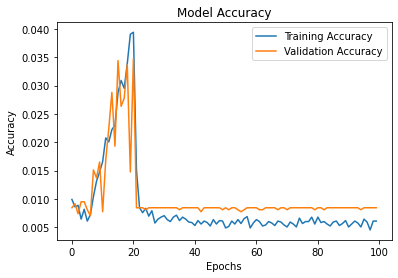

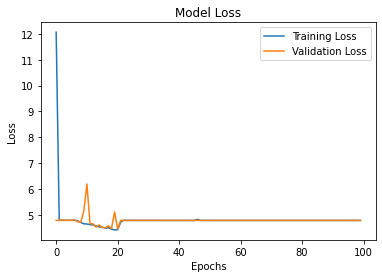

In [10]:
epochs = 100

model = import_model(conv_model_type='resnet', input_shape=(224, 224, 3), weights=None, train_state=True, custom_model=configuration_1, lr=1e-3)

history = model.fit(
    train_generator, 
    epochs = epochs,
    steps_per_epoch = nb_train_samples//batch_size,
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 1, 
    shuffle = True
)

plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

In [11]:
model.save('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/model_final_scratch')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/model_final_scratch/assets


In [12]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/model_final_scratch')

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 custom_config_1 (Sequential  (None, 120)              415364216 
 )                                                               
                                                                 
Total params: 438,951,928
Trainable params: 438,898,808
Non-trainable params: 53,120
_________________________________________________________________


In [14]:
model.layers[0].summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
model.layers[1].summary()

Model: "custom_config_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 4096)              411045888 
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              4195328   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 120)               123000    
                                                                 
Total params: 415,364,216
Trainable params: 415,364

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/Images_test',
    seed=1,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False)

Found 3597 images belonging to 120 classes.


In [17]:
pred= model.predict(test_generator, steps=len(test_generator), verbose=1)

113/113 [==============================] - 1130s 10s/step


In [18]:
predicted_class_indices = np.argmax(pred,axis=1)
labels = (test_generator.class_indices)
labels2 = dict((v,k) for k,v in labels.items())
predictions = [labels2[k] for k in predicted_class_indices]
y_true = [labels2[k] for k in test_generator.classes]

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(y_pred, y_true, class_indices):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(28,28))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(class_indices, rotation=90, fontsize=6)
    ax.yaxis.set_ticklabels(class_indices, rotation=0, fontsize=6)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_true, y_pred))

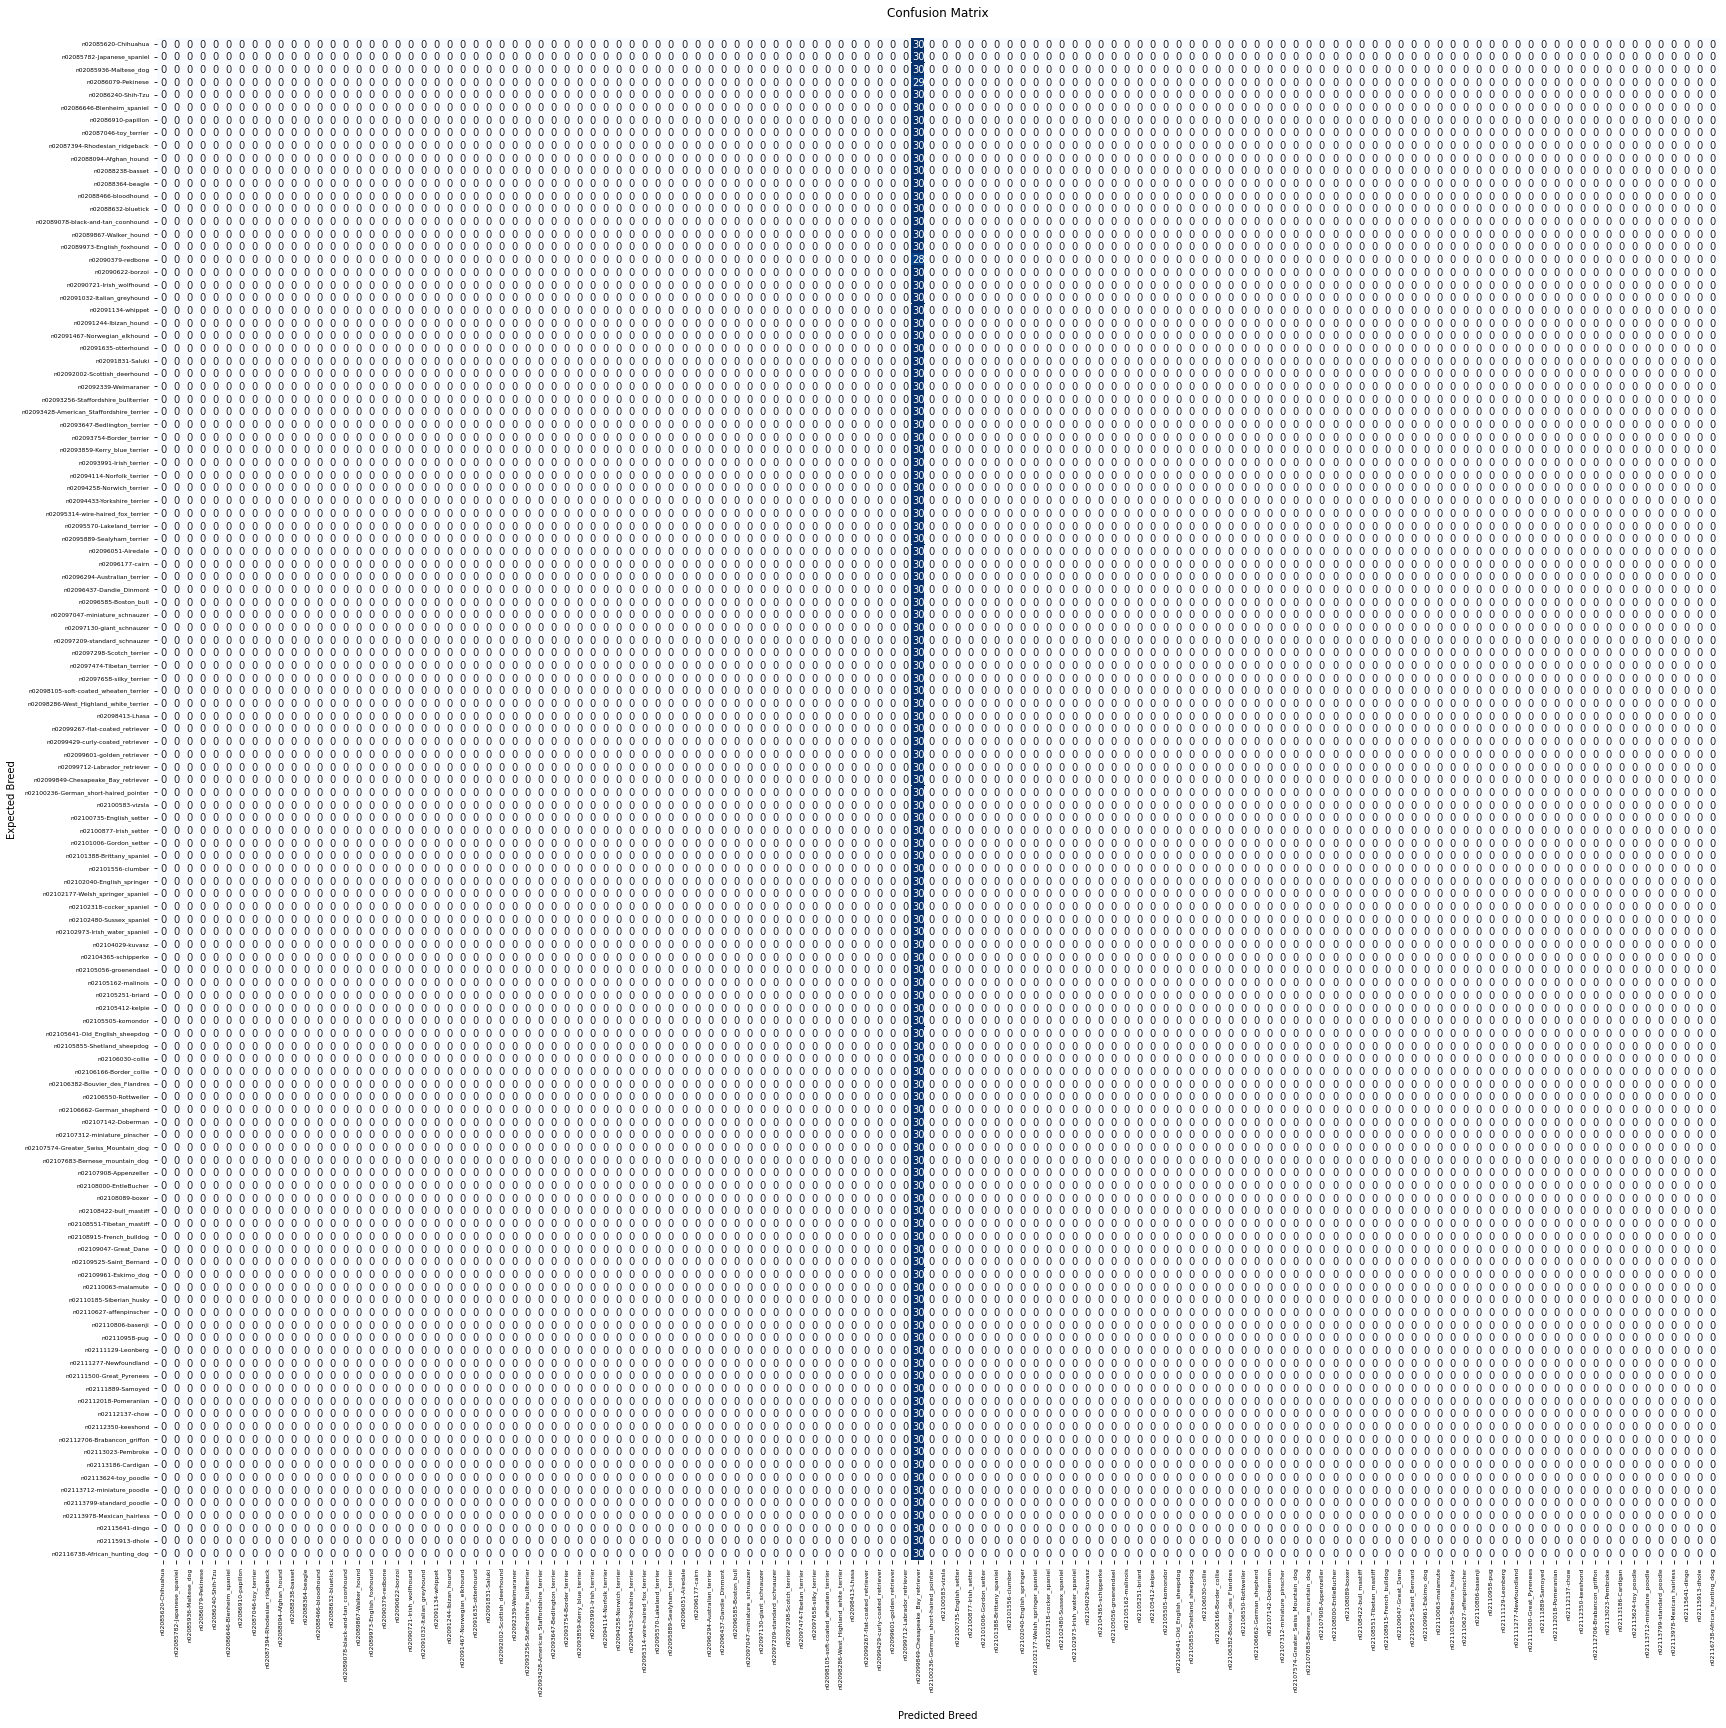




                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.00      0.00      0.00        30
              n02085782-Japanese_spaniel       0.00      0.00      0.00        30
                   n02085936-Maltese_dog       0.00      0.00      0.00        30
                      n02086079-Pekinese       0.00      0.00      0.00        29
                      n02086240-Shih-Tzu       0.00      0.00      0.00        30
              n02086646-Blenheim_spaniel       0.00      0.00      0.00        30
                      n02086910-papillon       0.00      0.00      0.00        30
                   n02087046-toy_terrier       0.00      0.00      0.00        30
           n02087394-Rhodesian_ridgeback       0.00      0.00      0.00        30
                  n02088094-Afghan_hound       0.00      0.00      0.00        30
                        n02088238-basset       0.00      0.00      0.00        30
            

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
evaluate_model(predictions, y_true, test_generator.class_indices.keys())